<a href="https://colab.research.google.com/github/kmk0105-S2/CapstoneDesign-25/blob/sunyp17-patch-1/SingleModality_clinicalData_XG_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import

In [4]:
!pip install catboost optuna

In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
import optuna
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    roc_auc_score, recall_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
    ,precision_score, average_precision_score, confusion_matrix
)

from google.colab import drive

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Loading

In [7]:
FILE_PATH = '/content/drive/My Drive/start/data/'
CSV_FILE_NAME = 'Ovarian_patient_data.csv'

In [8]:
CSV_FILE_PATH = Path(FILE_PATH) / CSV_FILE_NAME

In [9]:
try:
    df_clinical = pd.read_csv(CSV_FILE_PATH)
    print(f"Data loaded successfully from: {CSV_FILE_PATH.name}")
except FileNotFoundError:
    print(f"[ERROR] CSV file not found at {CSV_FILE_PATH}")
    exit()
except Exception as e:
    print(f"[ERROR] Error loading CSV file: {e}")
    exit()

Data loaded successfully from: Ovarian_patient_data.csv


# 2. Preprocessing

In [11]:
#RiskLabel 예측

# targets
# risk label만 예측하도록 수정
y_risk = df_clinical["RiskLabel"]

X_raw = df_clinical.drop(columns=["RiskLabel"])

if "Timestamp" in X_raw.columns:
    X_raw = X_raw.drop(columns=["Timestamp"])

In [12]:
#Train/Validation Split
train_idx, val_idx = train_test_split(
    df_clinical.index,
    test_size=0.2,
    random_state=42,
    stratify=y_risk
)

y_risk_train = y_risk.loc[train_idx]
y_risk_val= y_risk.loc[val_idx]


## for CatBoost

In [13]:
X_train_cb = X_raw.loc[train_idx]
X_val_cb   = X_raw.loc[val_idx]

categorical_cols_cb = X_train_cb.select_dtypes(
    include=['object']
).columns.tolist()

## for XGBoost

In [14]:
# 범주형 / 수치형 분리
categorical_cols_xgb = X_train_cb.select_dtypes(include=['object']).columns.tolist()
numeric_cols_xgb = X_train_cb.select_dtypes(include=['int64', 'float64']).columns.tolist()

# XGBoost 전처리 설정 (OneHot + numeric passthrough)

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_xgb),
        ('num', 'passthrough', numeric_cols_xgb)
    ]
)

# 데이터 누수 방지 - processor를 train에서만 fit/ val,test는 transform만
X_train_xgb = preprocessor_xgb.fit_transform(X_train_cb)
X_val_xgb   = preprocessor_xgb.transform(X_val_cb)

# 3. Training XGBoost

## RiskLabel 예측
- binary or multi-class

In [21]:
# --------------------------------------------------------------
# 모델 2 — RiskLabel (binary or multi-class)
# --------------------------------------------------------------
risk_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
)
risk_model.fit(X_train_xgb, y_risk_train)

risk_pred = risk_model.predict(X_val_xgb)
risk_prob_all = risk_model.predict_proba(X_val_xgb)

n_classes = len(np.unique(y_risk_val))

# Accuracy - 공통 metric
risk_acc = accuracy_score(y_risk_val, risk_pred)


# binary/multi class에 따라 metric 다르게 계산
# Recall
risk_recall = recall_score(
    y_risk_val,
    risk_pred,
    average='binary' if n_classes == 2 else 'macro'
)

# F1-score
risk_f1 = f1_score(
    y_risk_val,
    risk_pred,
    average='binary' if n_classes == 2 else 'macro'
)

# AUC
if n_classes == 2:
    # binary
    risk_prob = risk_prob_all[:, 1]
    risk_auc = roc_auc_score(y_risk_val, risk_prob)

    tn, fp, fn, tp = confusion_matrix(y_risk_val, risk_pred).ravel()
    risk_spec = tn / (tn + fp)

else:
    # multi-class
    risk_auc = roc_auc_score(
        y_risk_val,
        risk_prob_all,
        multi_class='ovr',
        average='macro'
    )
    risk_spec = None  # multi-class에서는 specificity 정의 애매함

#Precision

risk_precision = precision_score(
    y_risk_val,
    risk_pred,
    average='binary' if n_classes == 2 else 'macro'
)


#PR-AUC

if n_classes == 2:
    # binary PR-AUC
    risk_pr_auc = average_precision_score(y_risk_val, risk_prob)
else:
    # multi-class PR-AUC (one-vs-rest)
    risk_pr_auc = average_precision_score(
        y_risk_val,
        risk_prob_all,
        average='macro'
    )


#Specificity

def multiclass_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specs = []
    for i in range(cm.shape[0]):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specs.append(spec)
    return np.mean(specs)

if n_classes == 2:
    # 이미 계산한 binary specificity 사용
    risk_specificity = risk_spec
else:
    risk_specificity = multiclass_specificity(y_risk_val, risk_pred)

#Confusion Matrix

risk_cm = confusion_matrix(y_risk_val, risk_pred)



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost Results

In [43]:
results_xgboost = {
    "RiskLabel": {
        "Accuracy": risk_acc,
        "Recall": risk_recall,
        "Precision": risk_precision,
        "F1": risk_f1,
        "ROC_AUC": risk_auc,
        "PR_AUC": risk_pr_auc,
        "Specificity": risk_specificity,
        "Confusion_Matrix": risk_cm
    }
}

# 4. Training RF

In [31]:
risk_model_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

risk_model_rf.fit(X_train_xgb, y_risk_train)

risk_pred_rf = risk_model_rf.predict(X_val_xgb)
risk_prob_all_rf = risk_model_rf.predict_proba(X_val_xgb)

n_classes = len(np.unique(y_risk_val))

#Accuracy
risk_acc_rf = accuracy_score(y_risk_val, risk_pred_rf)

#Recall
risk_recall_rf = recall_score(
    y_risk_val,
    risk_pred_rf,
    average='binary' if n_classes == 2 else 'macro'
)

#f1-score
risk_f1_rf = f1_score(
    y_risk_val,
    risk_pred_rf,
    average='binary' if n_classes == 2 else 'macro'
)

#ROC-AUC + Specificity (binary / multi 분기
if n_classes == 2:
    risk_prob_rf = risk_prob_all_rf[:, 1]
    risk_auc_rf = roc_auc_score(y_risk_val, risk_prob_rf)

    tn, fp, fn, tp = confusion_matrix(y_risk_val, risk_pred_rf).ravel()
    risk_spec_rf = tn / (tn + fp)

else:
    risk_auc_rf = roc_auc_score(
        y_risk_val,
        risk_prob_all_rf,
        multi_class='ovr',
        average='macro'
    )
    risk_spec_rf = None

# Precision
risk_precision_rf = precision_score(
    y_risk_val,
    risk_pred_rf,
    average='binary' if n_classes == 2 else 'macro'
)

#PR-AUC
if n_classes == 2:
    risk_pr_auc_rf = average_precision_score(y_risk_val, risk_prob_rf)
else:
    risk_pr_auc_rf = average_precision_score(
        y_risk_val,
        risk_prob_all_rf,
        average='macro'
    )


#Specificity
if n_classes == 2:
    risk_specificity_rf = risk_spec_rf
else:
    risk_specificity_rf = multiclass_specificity(y_risk_val, risk_pred_rf)

# Confusion matrix
risk_cm_rf = confusion_matrix(y_risk_val, risk_pred_rf)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Random Forest Results

In [44]:
results_rf = {
    "RiskLabel": {
        "Accuracy": risk_acc_rf,
        "Recall": risk_recall_rf,
        "Precision": risk_precision_rf,
        "F1": risk_f1_rf,
        "ROC_AUC": risk_auc_rf,
        "PR_AUC": risk_pr_auc_rf,
        "Specificity": risk_specificity_rf,
        "Confusion_Matrix": risk_cm_rf
    }
}


### 성능 결과


In [46]:
#XGBoost
print("===== XGBoost RiskLabel Evaluation =====")

for metric, value in results_xgboost["RiskLabel"].items():
    if metric != "Confusion_Matrix":
        print(f"{metric:15s}: {value:.4f}")

print("\nConfusion Matrix:")
print(results_xgboost["RiskLabel"]["Confusion_Matrix"])

#RF
print("===== RandomForest RiskLabel Evaluation =====")

for metric, value in results_rf["RiskLabel"].items():
    if metric != "Confusion_Matrix":
        print(f"{metric:15s}: {value:.4f}")

print("\nConfusion Matrix:")
print(results_rf["RiskLabel"]["Confusion_Matrix"])


===== XGBoost RiskLabel Evaluation =====
Accuracy       : 0.5995
Recall         : 0.2500
Precision      : 0.1499
F1             : 0.1874
ROC_AUC        : 0.4981
PR_AUC         : 0.2494
Specificity    : 0.7500

Confusion Matrix:
[[23993     0     0     0]
 [ 8018     0     0     0]
 [ 6014     0     0     0]
 [ 1995     0     0     0]]
===== RandomForest RiskLabel Evaluation =====
Accuracy       : 0.5995
Recall         : 0.2500
Precision      : 0.1499
F1             : 0.1874
ROC_AUC        : 0.5008
PR_AUC         : 0.2508
Specificity    : 0.7500

Confusion Matrix:
[[23993     0     0     0]
 [ 8018     0     0     0]
 [ 6014     0     0     0]
 [ 1995     0     0     0]]


# 5. Visualization

In [37]:
def results_to_df(results, model_name):
    rows = []
    for task, metrics in results.items():
        for metric, value in metrics.items():
            rows.append({
                "Model": model_name,
                "Task": task,
                "Metric": metric,
                "Value": value
            })
    return pd.DataFrame(rows)

df_xgb = results_to_df(results_xgboost, "XGBoost")
df_rf = results_to_df(results_rf, "RandomForest")
df_rf_plot = df_rf[~df_rf["Metric"].isin(["Confusion_Matrix"])]


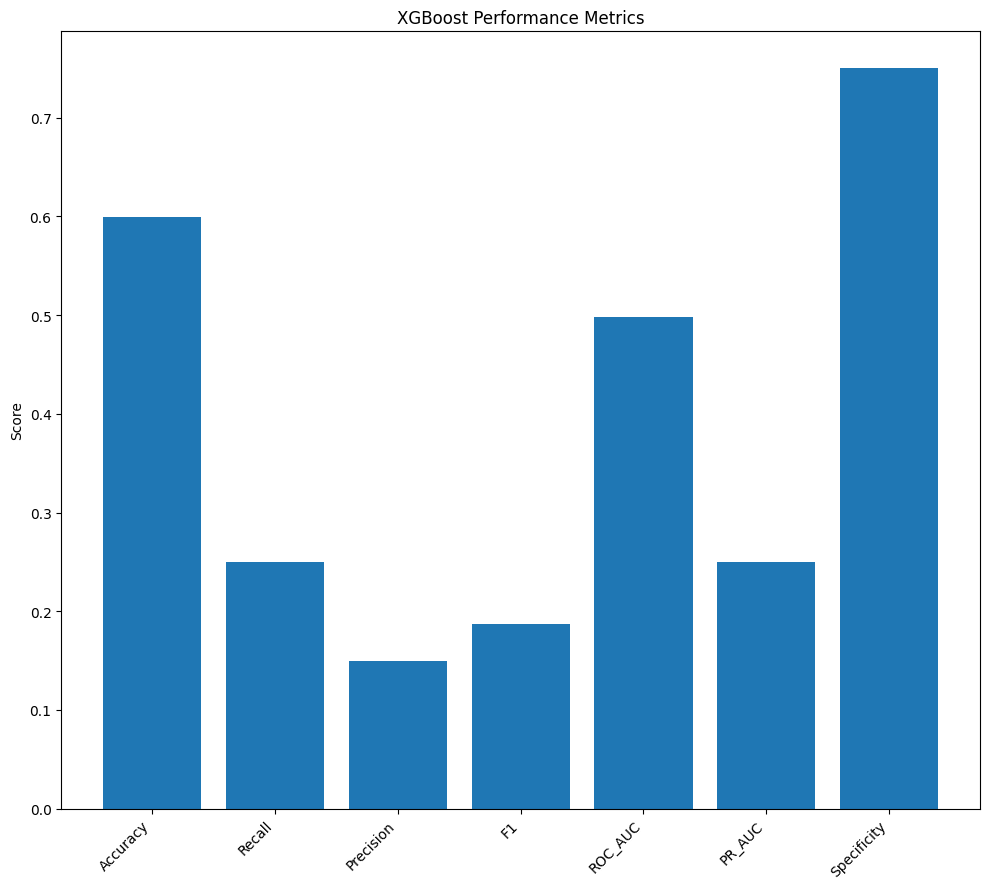

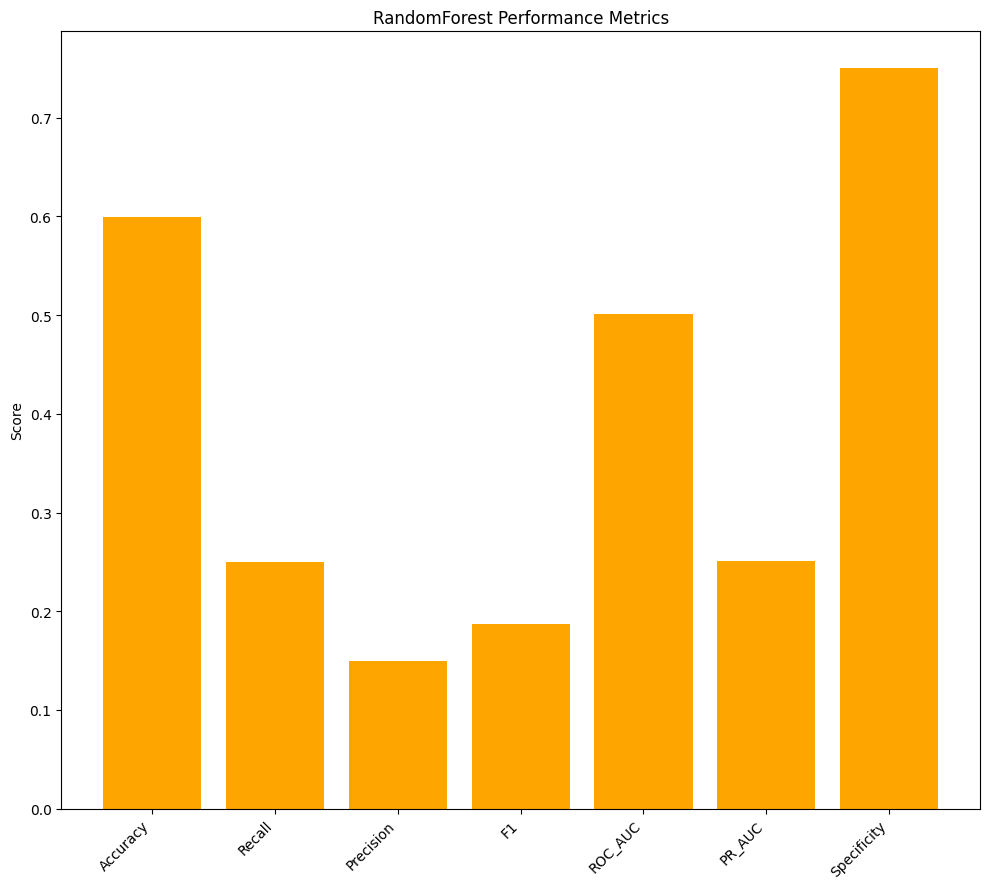

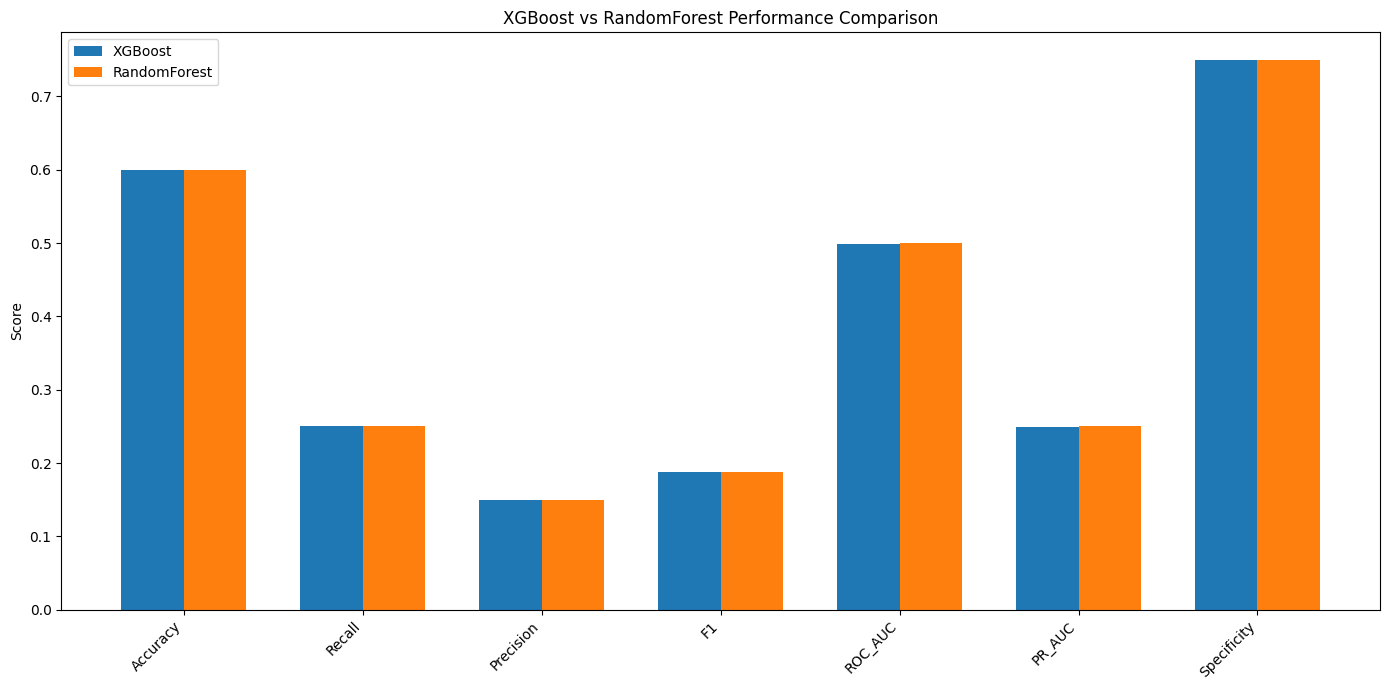

In [40]:
# XGBoost

df_xgb_plot = df_xgb[~df_xgb["Metric"].isin(["Confusion_Matrix"])]

plt.figure(figsize=(10, 9))

labels = df_xgb_plot["Task"] + "" + df_xgb_plot["Metric"]
plt.bar(labels, df_xgb_plot["Value"])

plt.title("XGBoost Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# RF

plt.figure(figsize=(10, 9))

labels_rf = df_rf_plot["Task"] + "" + df_rf_plot["Metric"]
plt.bar(labels_rf, df_rf_plot["Value"], color="orange")

plt.title("RandomForest Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# XGBoost vs RF
df_compare = pd.merge(
    df_xgb_plot,
    df_rf_plot,
    on=["Task", "Metric"],
    suffixes=("_XGB", "_RF")
)

x = np.arange(len(df_compare))
width = 0.35

plt.figure(figsize=(14, 7))

plt.bar(
    x - width/2,
    df_compare["Value_XGB"],
    width,
    label="XGBoost"
)

plt.bar(
    x + width/2,
    df_compare["Value_RF"],
    width,
    label="RandomForest"
)

plt.xticks(
    x,
    df_compare["Task"] + "" + df_compare["Metric"],
    rotation=45,
    ha="right"
)

plt.ylabel("Score")
plt.title("XGBoost vs RandomForest Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()


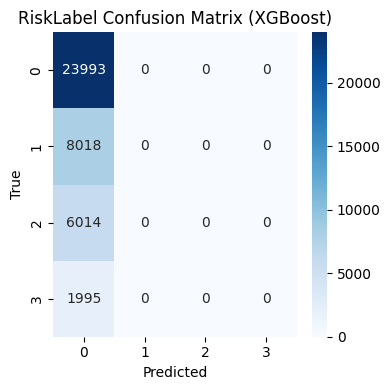

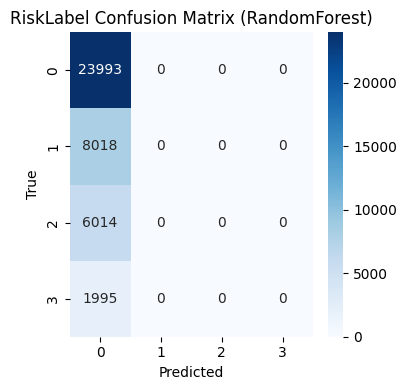

In [45]:
# Confusion Matrix 용 -> confusion matrix는 원본 그대로 제시하는 게 표준
import seaborn as sns
import matplotlib.pyplot as plt

cm = results_xgboost["RiskLabel"]["Confusion_Matrix"]

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("RiskLabel Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

cm_rf = results_rf["RiskLabel"]["Confusion_Matrix"]

plt.figure(figsize=(4, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("RiskLabel Confusion Matrix (RandomForest)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
